# Stability at the 12m tower


__Problem Statement__:
Stability is normally estimated using at most a handful of point observations. With DTS we can continuously define the gradient using very fine resolution temperature observations. But, what effect does defining stability through the DTS have relative to the traditional observations method?

__Goals of Notebook__:
- Evaluate the DTS stability estimates (OLS and Bayes GLM) and the CSAT derived stability
- Understand what contributes to the largest errors in the point-estimates of stability
- Investigate the factors that contribute to the (more accurately) defined stability from DTS

DTS stability were estimated using a log-linear Bayes GLM assuming that errors were distributed as Student's t distributions. These inferences were made in `bayesian-GLM_estimate-dTdz.ipynb`

# 1. Import and formatting

In [15]:
# Data and methods libraries
import numpy as np
import xarray as xr
import scipy.stats
import pandas as pd

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import copy
import pymc3 as pm
import warnings
# There are bunch of useless warnings about empty slices where I dont't have data.
# So I just blanket ignore them. Yolo.
warnings.simplefilter("ignore")

## Format plots

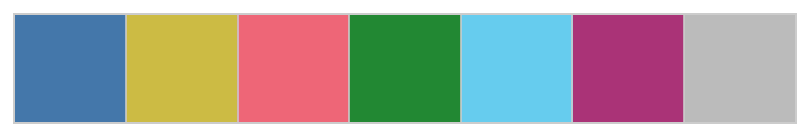

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = ['#4477AA', '#CCBB44', '#EE6677', '#228833', '#66CCEE', '#AA3377', '#BBBBBB']
sns.set_palette(sns.color_palette(tol_bright_reorder))
sns.palplot(tol_bright_reorder)

## Directories

In [3]:
dir_pre = os.path.join('/Users/karllapo/Dropbox/DarkMix/proj/DarkMix_Voitsumra/')

# Met data
dir_logger_data = os.path.join(dir_pre, 'logger_data')
dir_aws_data = os.path.join(dir_logger_data, 'AWS')
dir_csat_stats = os.path.join(dir_logger_data, 'CSATs', 'stats')
dir_csat_flux = os.path.join(dir_logger_data, 'CSATs', 'fluxes')
dir_csat_corr = os.path.join(dir_logger_data, 'CSATs', 'csat-Ts-correction')
dir_ceil = os.path.join(dir_pre, 'love_dts/ESSD-repository/remote-sensing/ceilometer/')
dir_press = os.path.join(dir_logger_data, 'pressure')
dir_bayes_glm = os.path.join(dir_pre, 'love_dts', 'bayes_glm')
dir_homogenized_data = os.path.join(dir_pre, 'homogenized_data')

# Figures
dir_print = os.path.join(dir_pre, 'figures', 'AncillaryMet')


# 2. Load data

## 2.1 Homogenized data

Use the homogenized data from `homogenizing-stability-data.ipynb`

In [4]:
os.chdir(dir_homogenized_data)

sonic_1min = xr.open_dataset('sonics_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
sonic_10min = xr.open_dataset('sonics_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta = xr.open_dataarray('aws_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')
aws_2m_theta_10min = xr.open_dataarray('aws_pot-temp_10min_qc_tower-subset.v1-2021-02-22.nc')
tower = xr.open_dataset('tower_pot-temp_1s_qc_tower-subset.v1-2021-02-22.nc')
tower_1min = xr.open_dataset('tower_pot-temp_1min_qc_tower-subset.v1-2021-02-22.nc')


## 2.2 Tower 10min Bayesian modeling output

In [5]:
os.chdir(dir_bayes_glm)
tower_10min = xr.open_dataset('tower_10min_bayes_glm.nc')

## 2.2 Ceilometer, AWS, and pressure data

- Ceilometer for cloudiness
- AWS for radiation and RH

In [8]:
os.chdir(dir_ceil)
ceilo = xr.open_dataset('ceiolometer-combined-files_2019_June01-Aug15.nc')
ceilo = ceilo.reindex_like(sonic_1min.time, method='nearest')
ceilo_10min = ceilo.interp_like(tower_10min.time, method='nearest')

In [9]:
os.chdir(dir_aws_data)
aws_10min = xr.open_dataset('AWS_Voi_10min.nc')

## 2.3 Quickly estimate stability using the CSATs

In [10]:
sonic_10min['ols_m'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_r'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_p'] = (('time'), np.zeros(len(sonic_10min.time.values)))
sonic_10min['ols_b'] = (('time'), np.zeros(len(sonic_10min.time.values)))


In [11]:
for t in sonic_10min.time:
    ds = sonic_10min.sel(time=t).theta

    result_dts = scipy.stats.linregress(np.log(ds.z), ds.values)
    sonic_10min['ols_m'].loc[{'time': t}] = result_dts.slope
    sonic_10min['ols_r'].loc[{'time': t}] = result_dts.rvalue
    sonic_10min['ols_p'].loc[{'time': t}] = result_dts.pvalue
    sonic_10min['ols_b'].loc[{'time': t}] = result_dts.intercept

## 2.4 Create a gappy version of the 10min DTS tower data

In [12]:
dt = pd.date_range(
    start=pd.Timestamp(tower_10min.time[0].values),
    end=pd.Timestamp(tower_10min.time[-1].values),
    freq='10min',
)

tower_10min_nanfill = tower_10min.reindex(time=dt, tolerance=1, method='nearest')

# 3. Visualize

## 3.1 First, just the time series

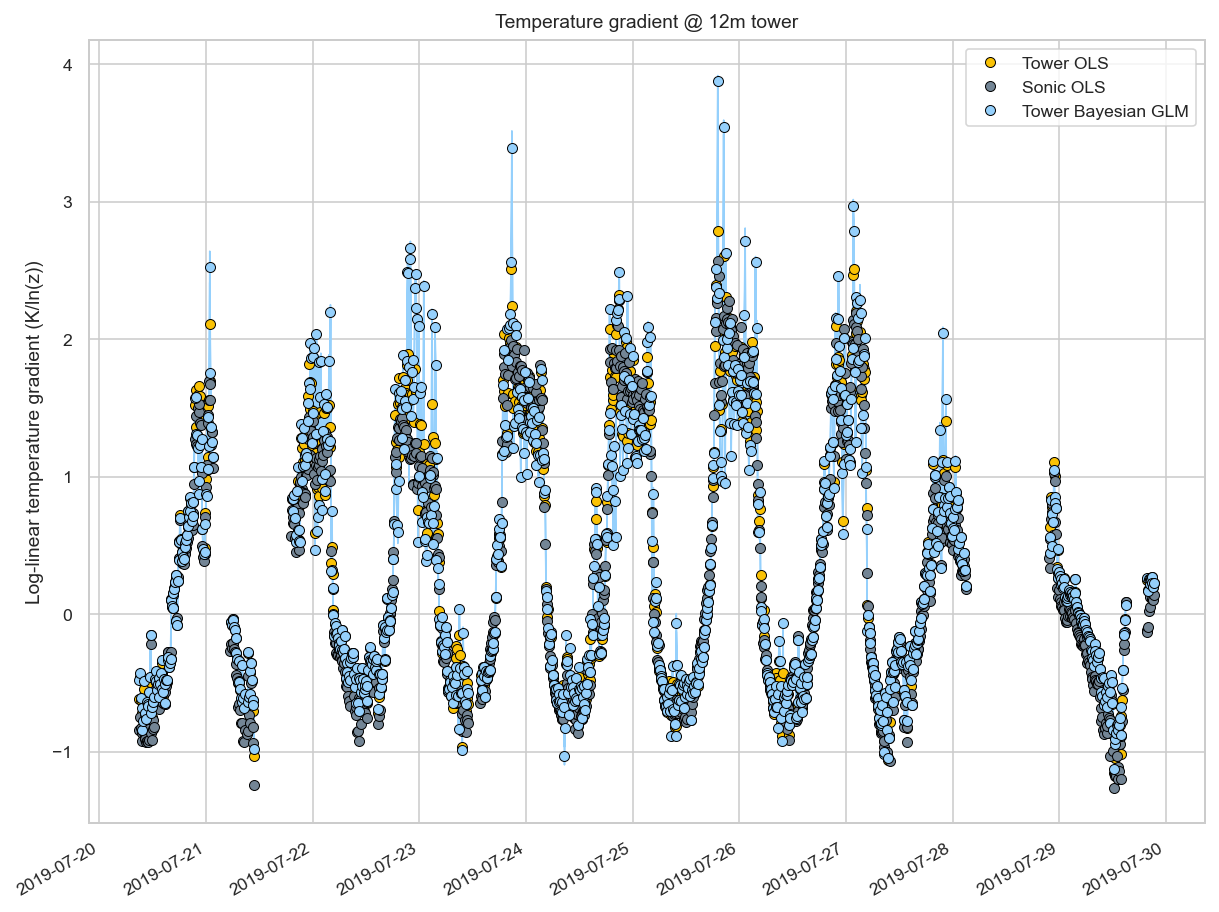

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.fill_between(
    tower_10min_nanfill.time,
    tower_10min_nanfill.b1_slope.mean(dim='draws') + tower_10min_nanfill.b1_slope.std(dim='draws'),
    tower_10min_nanfill.b1_slope.mean(dim='draws') - tower_10min_nanfill.b1_slope.std(dim='draws'),
    color='xkcd:light blue'
)

ax.plot(
    tower_10min.time,
    tower_10min.ols_m,
    color='xkcd:goldenrod',
    marker='.',
    linestyle='None',
    label='Tower OLS',
    markeredgecolor='k',
    markeredgewidth=0.5,
    markersize=10,
)

ax.plot(
    sonic_10min.time,
    sonic_10min.ols_m,
    color='xkcd:steel',
    marker='.',
    linestyle='None',
    label='Sonic OLS',
    markeredgecolor='k',
    markeredgewidth=0.5,
    markersize=10,
)

ax.plot(
    tower_10min.time,
    tower_10min.b1_slope.mean(dim='draws'),
    color='xkcd:light blue',
    marker='.',
    linestyle='None',
    label='Tower Bayesian GLM',
    markeredgecolor='k',
    markeredgewidth=0.5,
    markersize=10,
)

ax.legend()
ax.set_ylabel('Log-linear temperature gradient (K/ln(z))')
ax.set_title('Temperature gradient @ 12m tower')
fig.autofmt_xdate()

## 3.2 Comparing OLS to Bayes for DTS tower and sonics

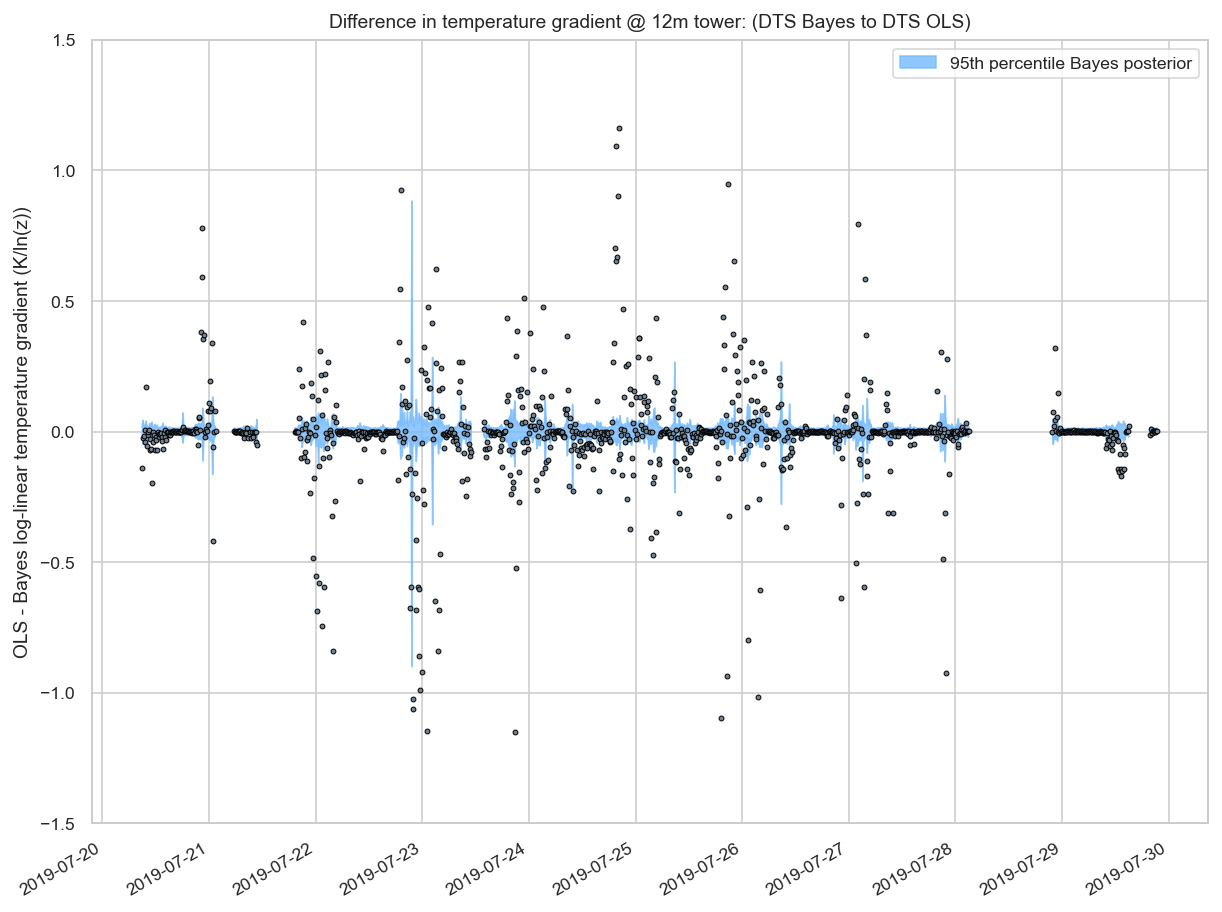

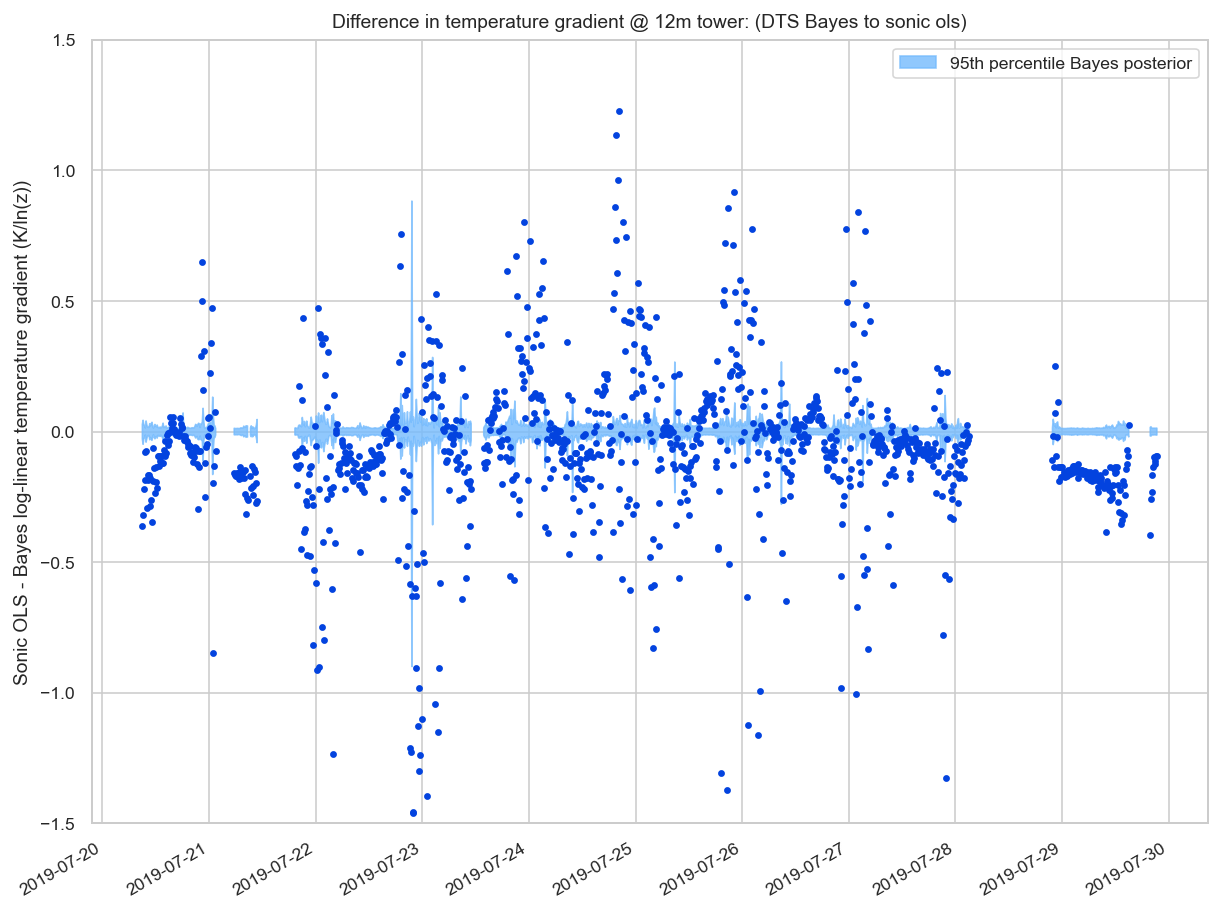

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.fill_between(
    tower_10min_nanfill.time,
    (tower_10min_nanfill.b1_slope.mean(dim='draws') - tower_10min_nanfill.b1_slope).quantile(0.1, dim='draws'),
    (tower_10min_nanfill.b1_slope.mean(dim='draws') - tower_10min_nanfill.b1_slope).quantile(0.9, dim='draws'),
    color='xkcd:sky blue',
    label='95th percentile Bayes posterior',
    alpha=0.8
)
ax.plot(
    tower_10min.time,
    tower_10min.ols_m - tower_10min.b1_slope.mean(dim='draws'),
    color='xkcd:steel',
    markeredgecolor='k',
    markeredgewidth=0.5,
    marker='.',
    linestyle='None',
)

ax.set_ylim(-1.5, 1.5)
ax.legend()
ax.set_ylabel('OLS - Bayes log-linear temperature gradient (K/ln(z))')
ax.set_title('Difference in temperature gradient @ 12m tower: (DTS Bayes to DTS OLS)')
fig.autofmt_xdate()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.fill_between(
    tower_10min_nanfill.time,
    (tower_10min_nanfill.b1_slope.mean(dim='draws') - tower_10min_nanfill.b1_slope).quantile(0.1, dim='draws'),
    (tower_10min_nanfill.b1_slope.mean(dim='draws') - tower_10min_nanfill.b1_slope).quantile(0.9, dim='draws'),
    color='xkcd:sky blue',
    label='95th percentile Bayes posterior',
    alpha=0.8
)
ax.plot(
    tower_10min.time,
    sonic_10min.ols_m - tower_10min.b1_slope.mean(dim='draws'),
    color='xkcd:blue',
    marker='.',
    linestyle='None',
)

ax.set_ylim(-1.5, 1.5)
ax.legend()
ax.set_ylabel('Sonic OLS - Bayes log-linear temperature gradient (K/ln(z))')
ax.set_title('Difference in temperature gradient @ 12m tower: (DTS Bayes to sonic ols)')
fig.autofmt_xdate()

The point observation derived slope clearly has some issues! That's a really cool result. Let's do a scatter plot to look at the distribution of errors.

## 3.3 Distribution of errors

Text(0.5, 0, "Mean Bayesian Student's GLM slope (K/ln(z))")

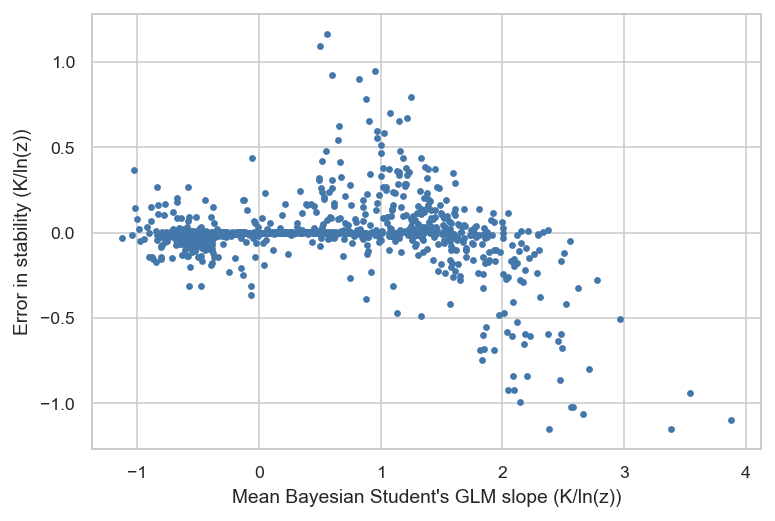

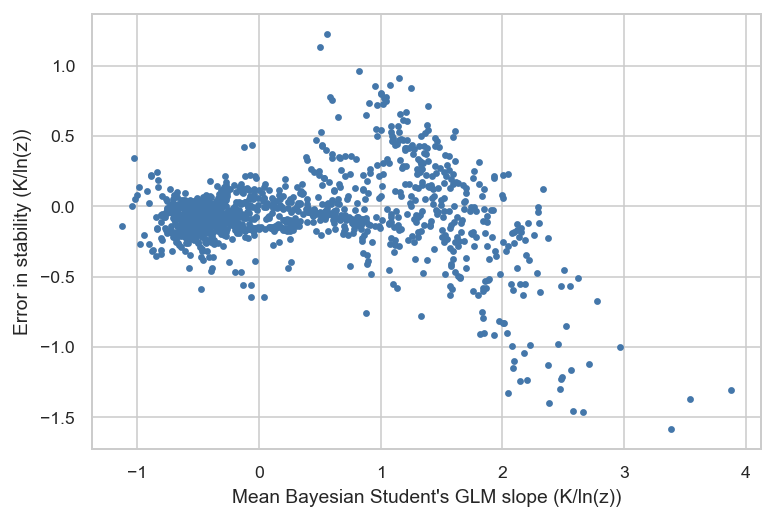

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    tower_10min.b1_slope.mean(dim='draws').values,
    (tower_10min.ols_m - tower_10min.b1_slope.mean(dim='draws')).values,
    linestyle='None',
    marker='.'
)
ax.set_ylabel('Error in stability (K/ln(z))')
ax.set_xlabel('Mean Bayesian Student\'s GLM slope (K/ln(z))')

fig, ax = plt.subplots(1, 1)
ax.plot(
    tower_10min.b1_slope.mean(dim='draws').values,
    (
        sonic_10min.reindex_like(tower_10min, method='nearest', tolerance=0).ols_m
        - tower_10min.b1_slope.mean(dim='draws')
    ).values,
    linestyle='None',
    marker='.'
)
ax.set_ylabel('Error in stability (K/ln(z))')
ax.set_xlabel('Mean Bayesian Student\'s GLM slope (K/ln(z))')

During unstable conditions, the point observations slightly underestimate the stability. During strongly stable conditions there is a clear problem in the point-observation stability.

The dashed vertical lines represent what I am eyeballing as "near" neutral conditions. The Bayesian Student's t-distribution GLM results in less neutral conditions and shifts the distribution towards a longer tail toward stable conditions (+ slopes). Let's verify the differences between the different methods for estimating stability.

# 4. When do the largest disagreements occur?

Here I will be referring to the disagreements from the DTS tower Bayes GLM stability as "errors" since there is a good reason to believe this slope more than the CSAT or OLS slopes.

## 4.1 The difference between the OLS and Student's t-distribution

When do we have the largest disagreements? Presumably from the time series it is during the night.

In [30]:
ds = copy.deepcopy(tower_10min)
ds['interval'] = (('time'), np.zeros_like(ds.ols_m))
ds['interval'] = ds['interval'].where((ds['time.hour'] > 5) & (ds['time.hour'] <= 22), 'night')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 5) | (ds['time.hour'] >= 9), 'morning')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 9) | (ds['time.hour'] >= 15), 'day')
ds['interval'] = ds['interval'].where((ds['time.hour'] < 15) | (ds['time.hour'] > 22), 'evening')

In [56]:
# Create a merged Dataset.
# Previously I worked with just the 4m CSAT. Here I include all of them for additional
# investigation.
slope_err_csat = (
    sonic_10min.reindex_like(tower_10min, method='nearest', tolerance=0).ols_m
    - tower_10min.b1_slope.mean(dim='draws')
)

ds_10min = xr.merge(
    [
#         sonic_10min.theta.sel(names='4m').rename('theta_sonic_4m').drop('z'),
#         sonic_10min.wTs.sel(names='4m').rename('wTs_sonic_4m').drop('z'),
#         sonic_10min.U_scalar_mean_rot.sel(names='4m').rename('U_sonic_4m').drop('z'),
#         tower_10min.b1_slope.mean(dim='draws'),
        sonic_10min.theta,
        sonic_10min.wTs,
        sonic_10min.U_scalar_mean_rot.rename('U_sonic'),
        slope_err_csat.rename('slope_err_csat'),
        ceilo_10min.tcc,
        aws_2m_theta_10min.rename('AWS_theta_2m'),
        aws_10min['Rlwd (CNR4)'].rename('LWdwn'),
        (aws_10min['Rlwd (CNR4)'] - aws_10min['Rlwu (CNR4)']).rename('LWnet'),
        aws_10min['Rswd (CNR4)'].rename('SWdwn'),
        ds['interval'],
    ],
)

df_10min = xr.Dataset.to_dataframe(
    ds_10min.drop(
        [
            'x', 'z', 'LAF',
            'northcones', 'unheated',
            'southcones', 'y',
            'heated', 'eastcones'
        ],
    errors='ignore',
    )
)

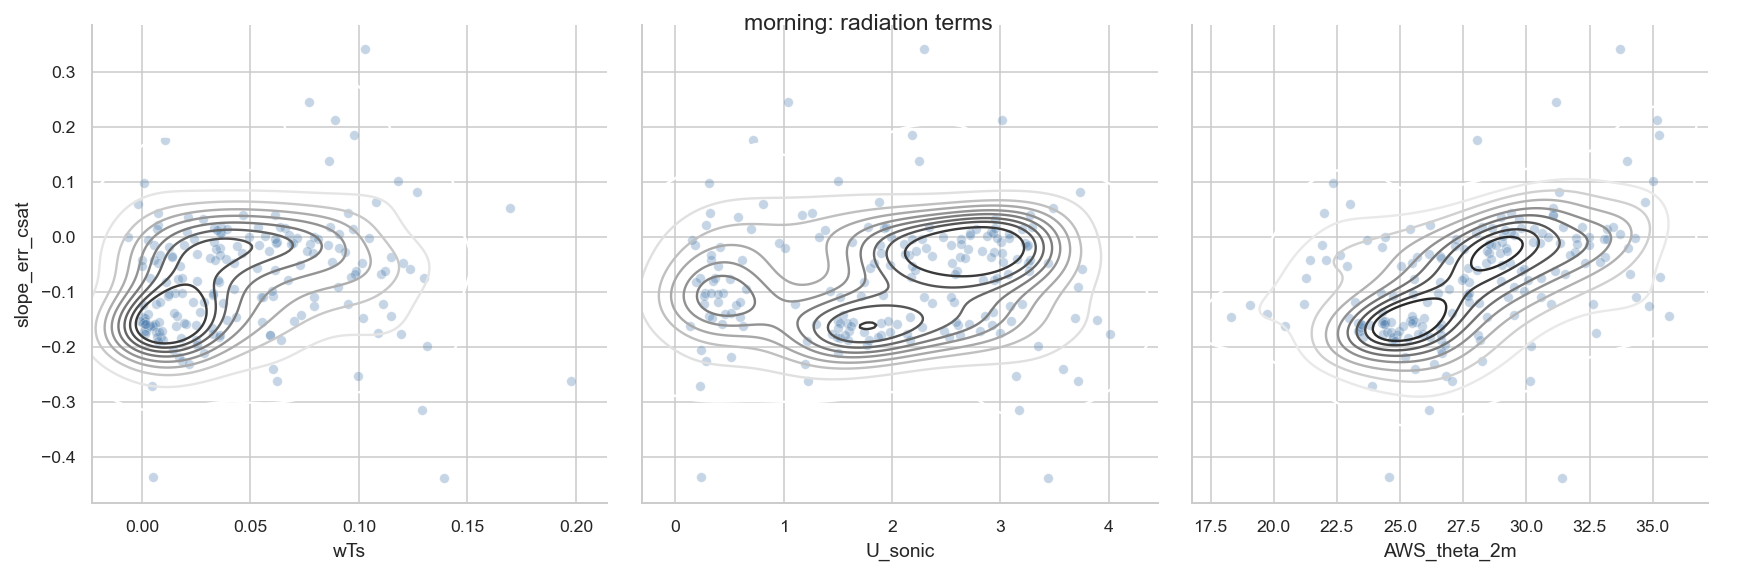

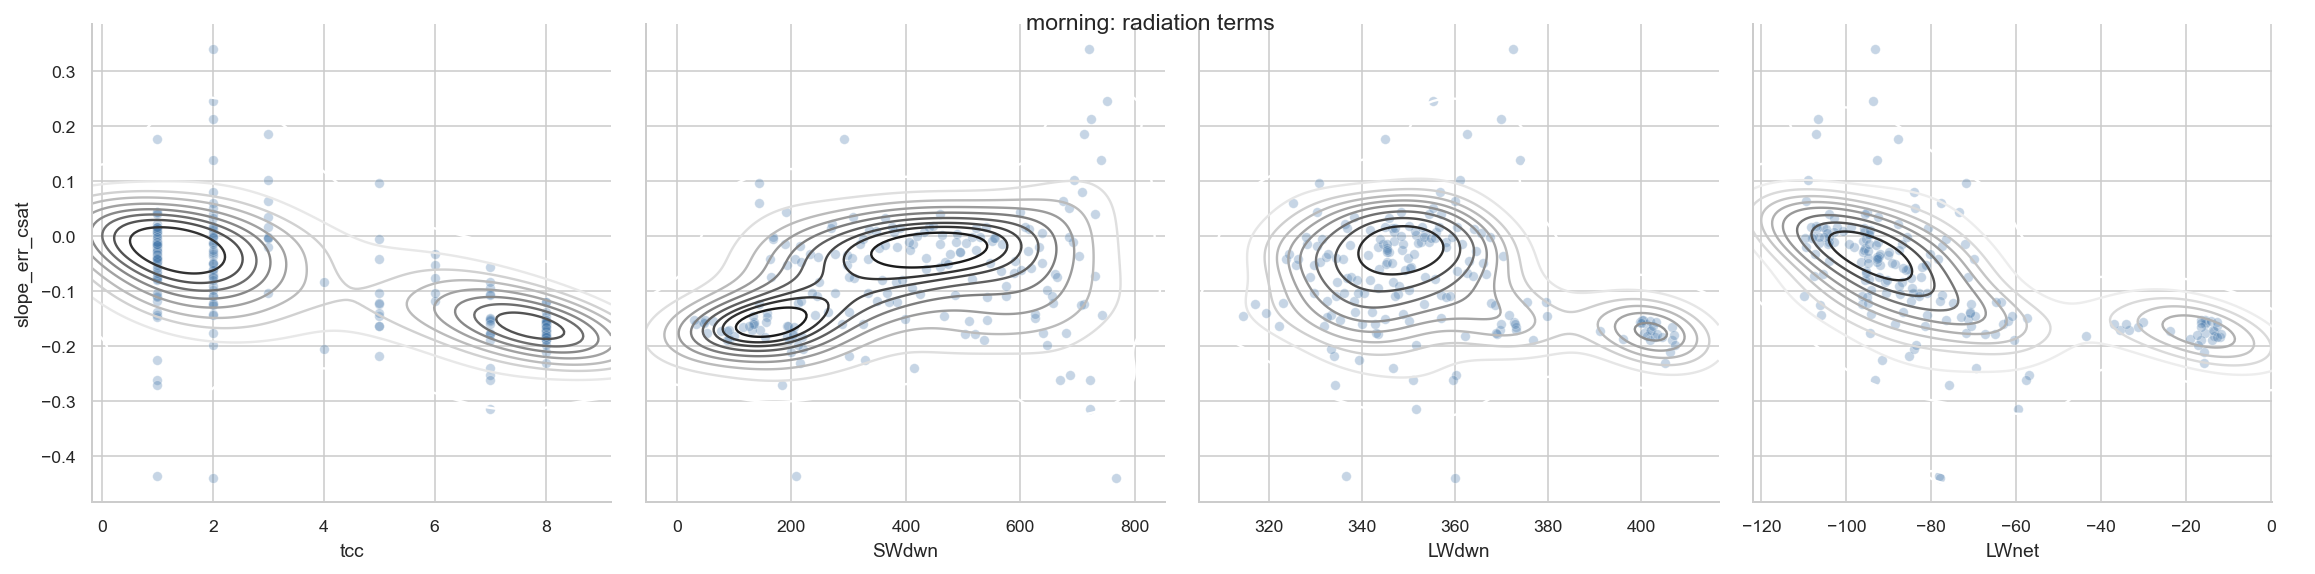

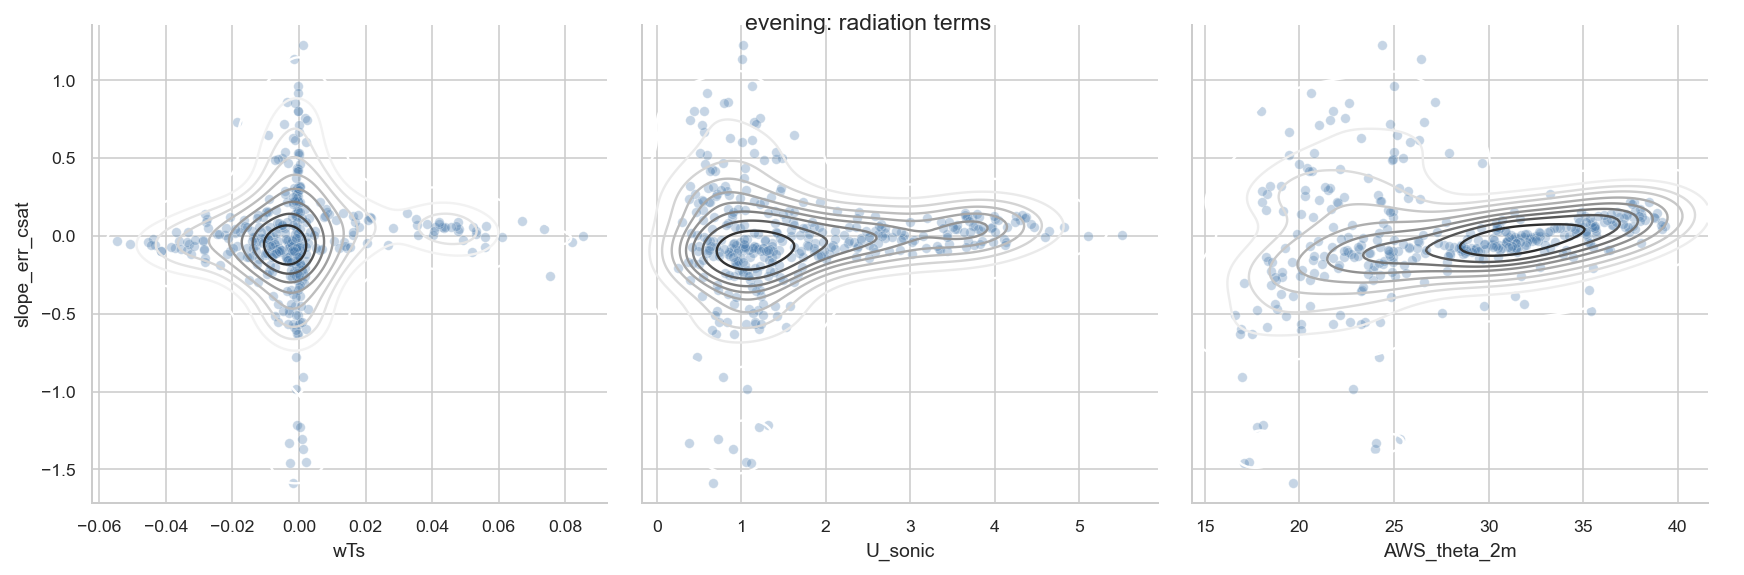

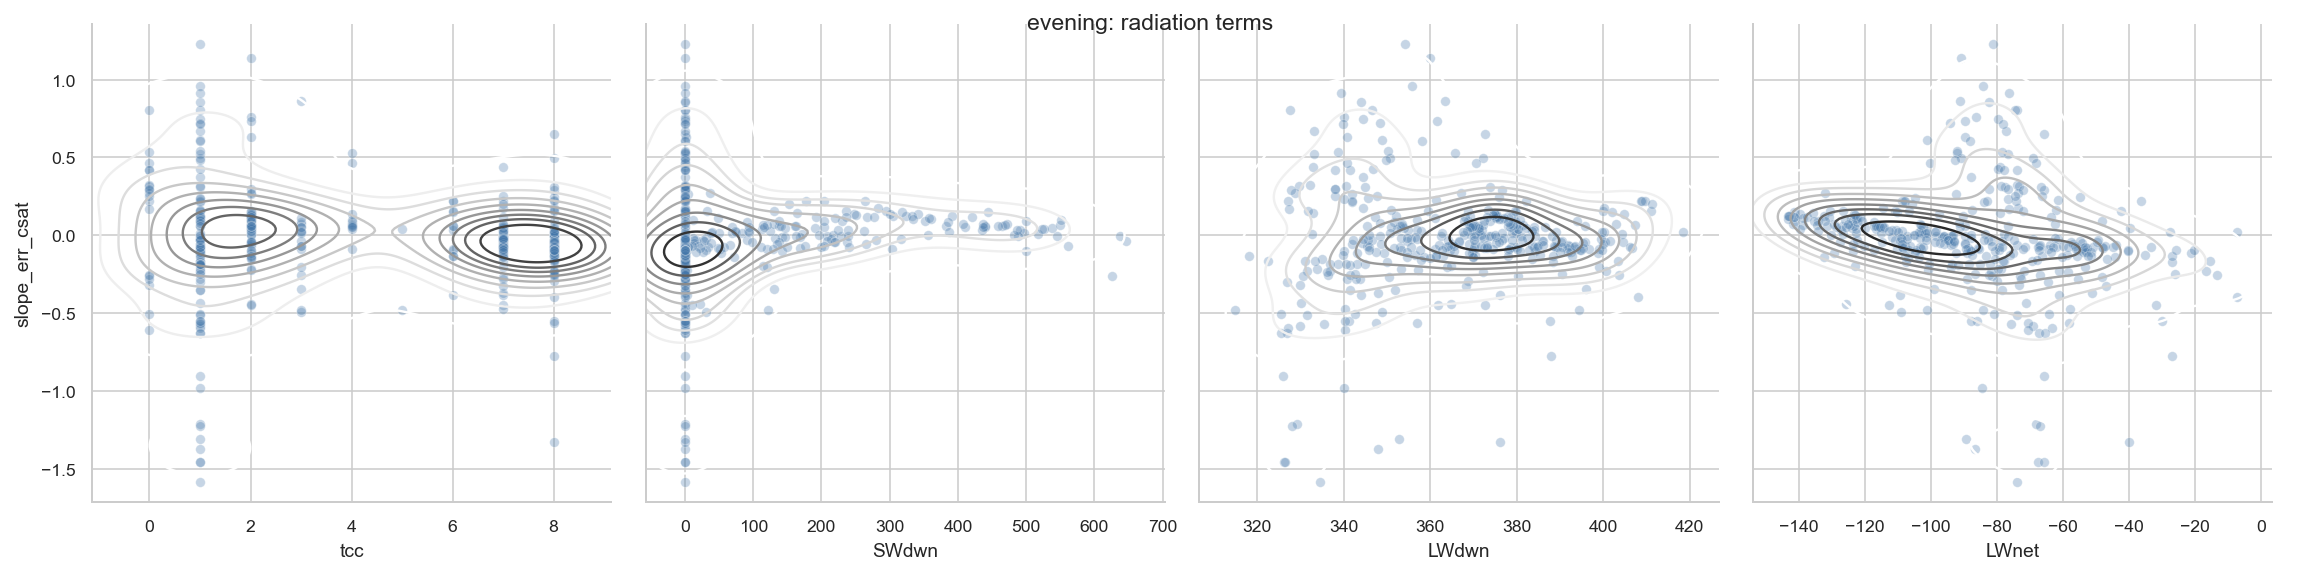

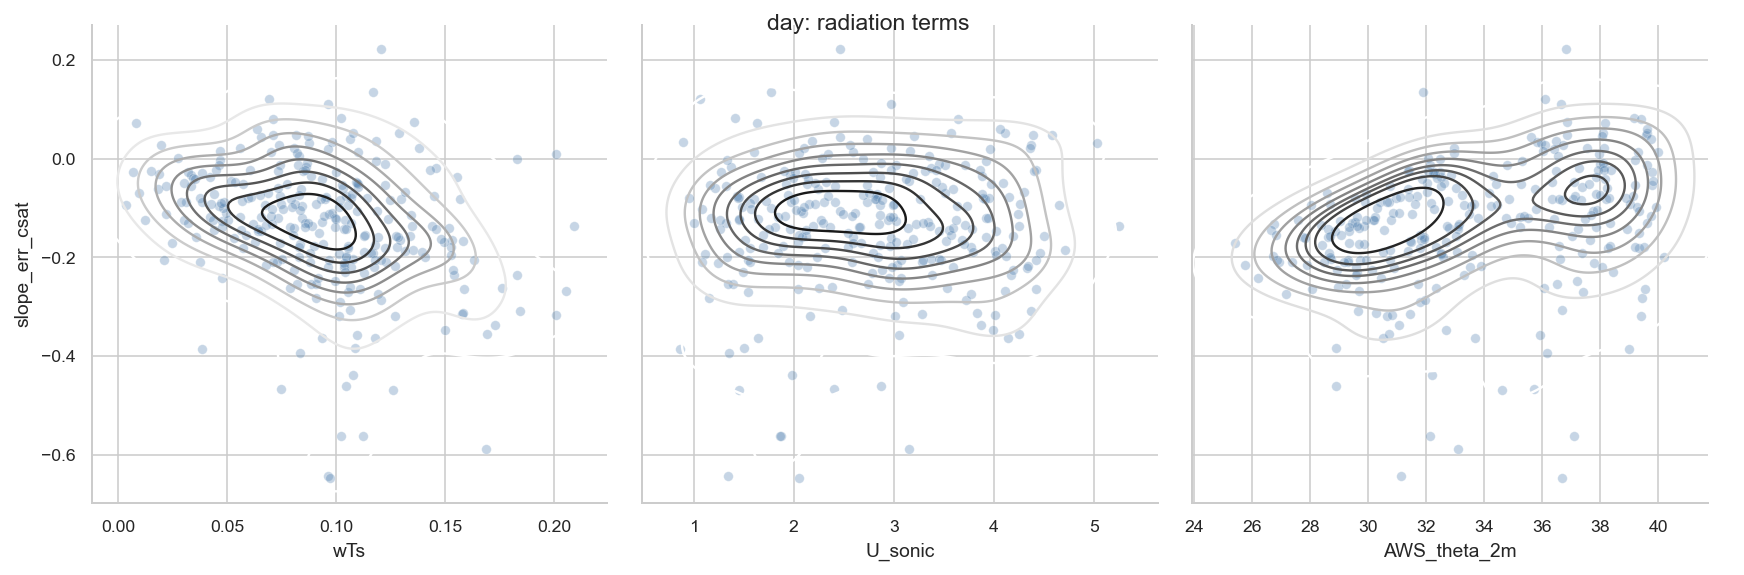

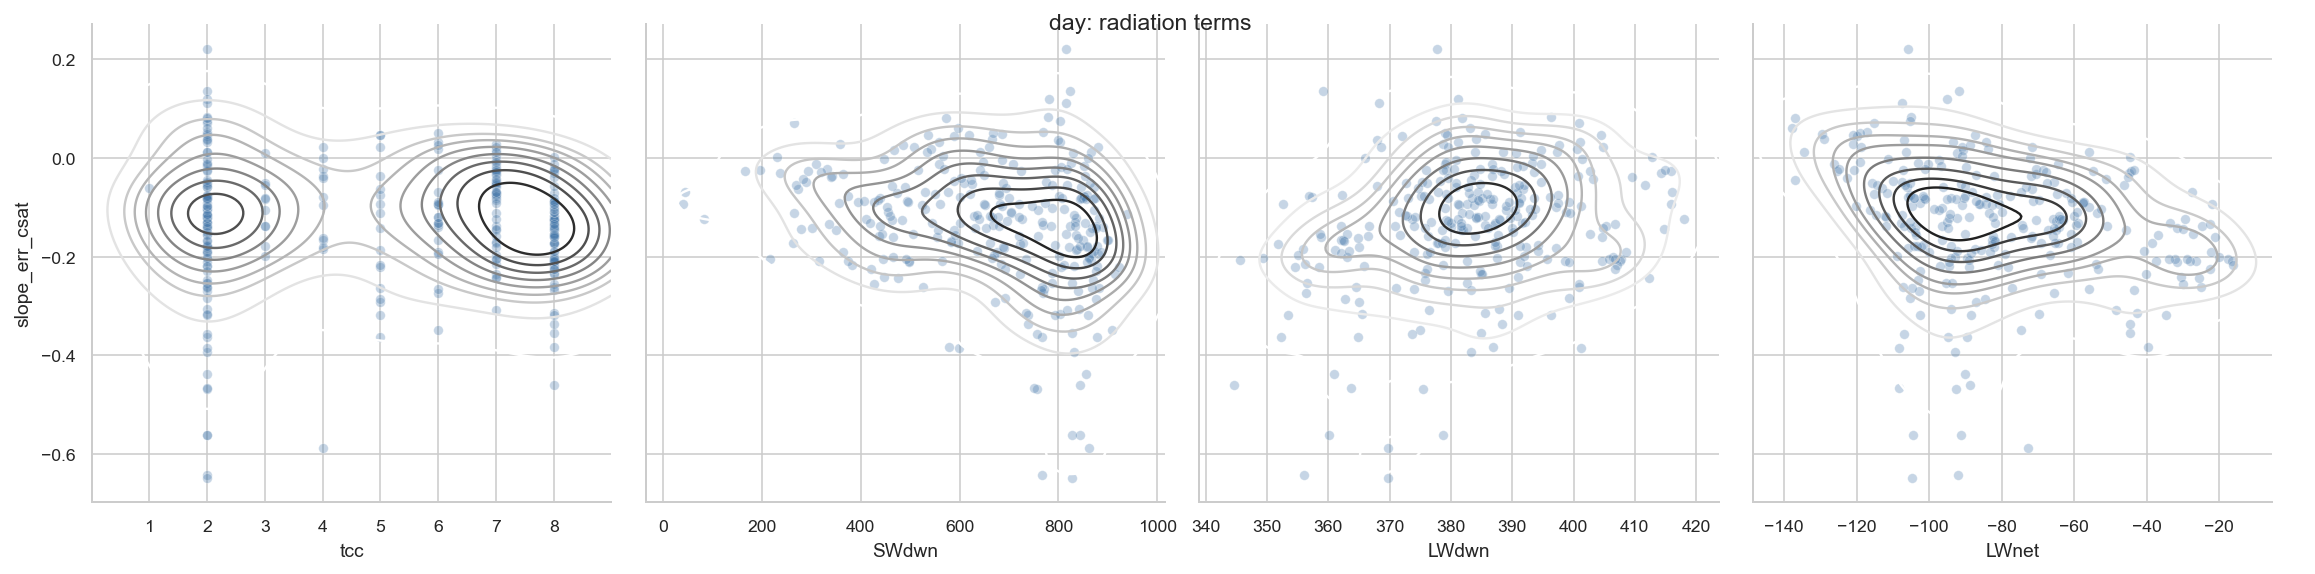

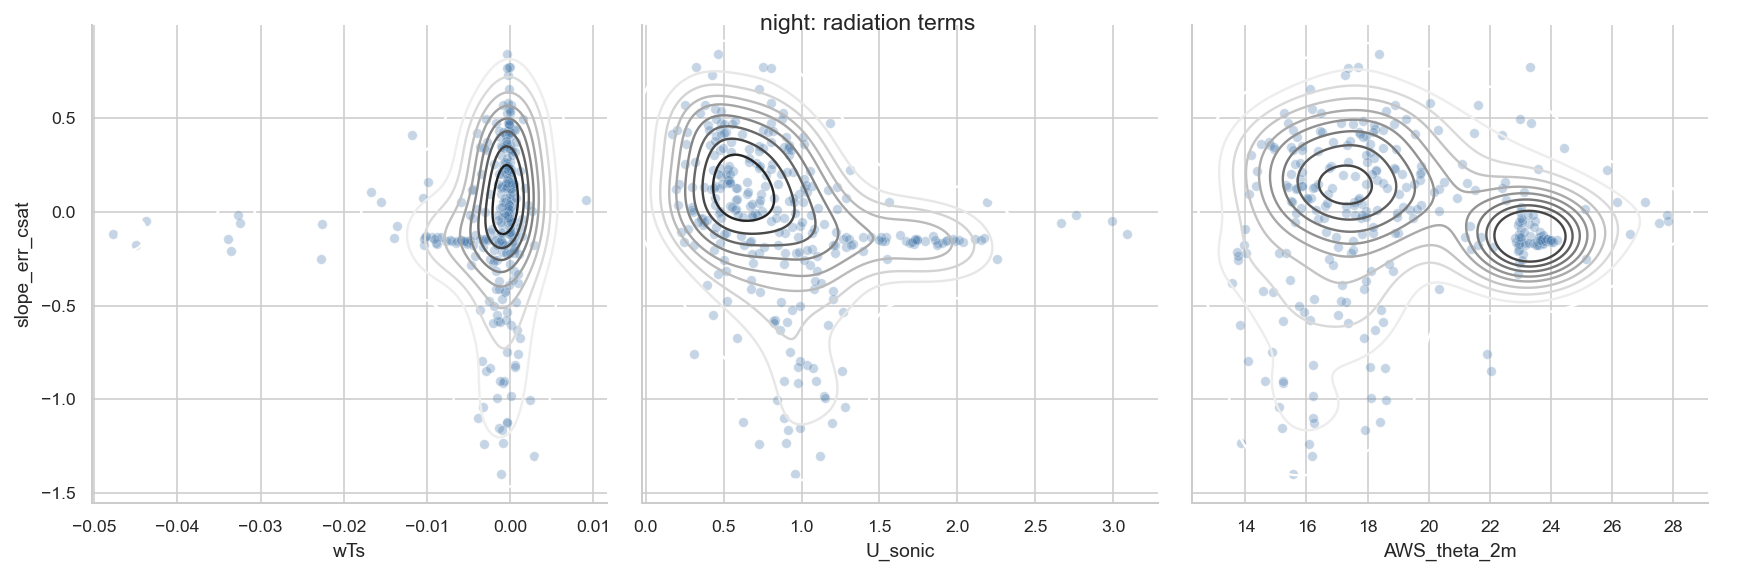

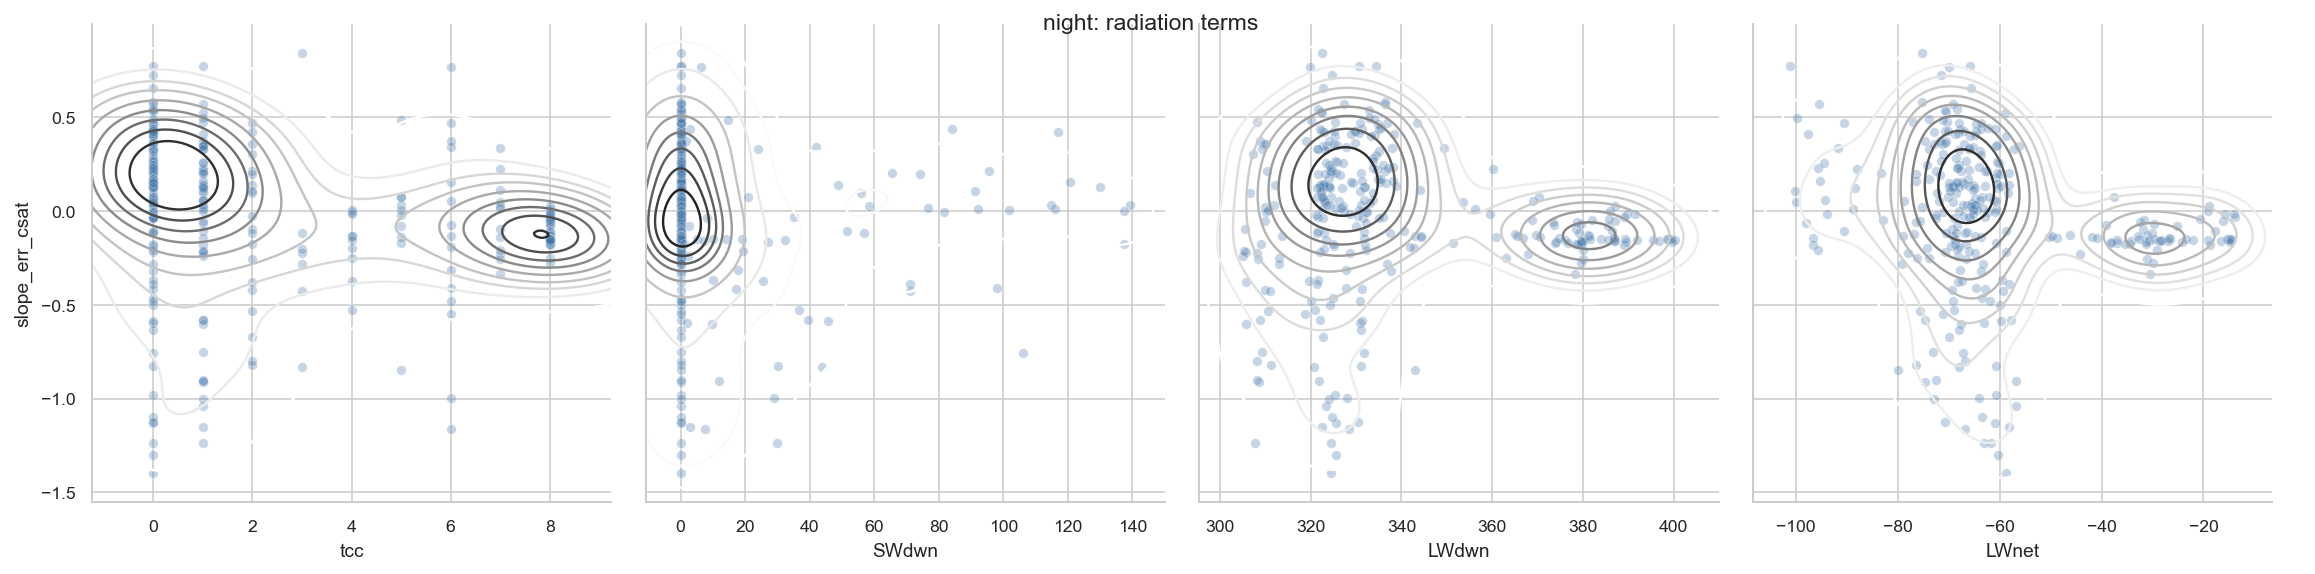

In [61]:
for interval in ['morning', 'evening', 'day', 'night']:
    # Turbulence terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["slope_err_csat"],
        x_vars=["wTs", "U_sonic", 'AWS_theta_2m'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')

    # Radiation terms
    g = sns.PairGrid(
        df_10min.where((df_10min.interval == interval)).loc['4m'],
        y_vars=["slope_err_csat"],
        x_vars=['tcc', 'SWdwn', 'LWdwn', 'LWnet'],
        height=4,
    )
    g.map(sns.kdeplot, cut=1, cmap="gray_r")
    g.map(sns.scatterplot, alpha=0.3)
    g.add_legend()
    plt.gcf().suptitle(interval + ': radiation terms')